In [ ]:
pip install xgboost seaborn joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import defaultdict
import xgboost as xgb

from sklearn import model_selection, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.multiclass import unique_labels

# model saving
import pickle
from joblib import Parallel, delayed
import joblib

# heatmap
import seaborn as sn

from matplotlib import pyplot

In [ ]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
!gdown 15TpccOcO4zuG8iz4AZb6bRfMGYvGPCLf

Downloading...
From: https://drive.google.com/uc?id=1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF
To: /media/dlpc01/C2586CB0586CA53F/SWE421/tumor_gene_Symbol_dataset.csv
100%|███████████████████████████████████████| 1.38G/1.38G [48:01<00:00, 478kB/s]


# data process

In [ ]:
gene_symbol_mapping= pd.read_csv("./tumor_gene_Symbol_dataset.csv", sep=',')
gene_symbol_mapping = gene_symbol_mapping.sort_values(by=['Unnamed: 0'])
gene_symbol_mapping= gene_symbol_mapping.set_index('Unnamed: 0')
gene_symbol_mapping = gene_symbol_mapping[gene_symbol_mapping['cancer type abbreviation'].notna()]

gene_symbol_mapping

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,GBM,78.0,MALE,WHITE
TCGA-02-0055-01,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,GBM,62.0,FEMALE,WHITE
TCGA-02-2483-01,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,GBM,43.0,MALE,ASIAN
TCGA-02-2485-01,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,GBM,53.0,MALE,BLACK OR AFRICAN AMERICAN
TCGA-04-1331-01,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,OV,78.0,FEMALE,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,LIHC,64.0,MALE,WHITE
TCGA-ZS-A9CG-01,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,LIHC,55.0,MALE,WHITE
TCGA-ZT-A8OM-01,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,THYM,73.0,FEMALE,WHITE


In [ ]:
cancer_names= gene_symbol_mapping['cancer type abbreviation'].unique()

In [ ]:
gene_symbol_mapping['age_at_initial_pathologic_diagnosis']= gene_symbol_mapping['age_at_initial_pathologic_diagnosis'].astype(str)

d = defaultdict(LabelEncoder)
columns_to_encode = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

gene_symbol_mapping.loc[:,columns_to_encode] = gene_symbol_mapping.loc[:,columns_to_encode].apply(lambda x: d[x.name].fit_transform(x.fillna('0')))
gene_symbol_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, TCGA-02-0047-01 to TCGA-ZX-AA5X-01
Columns: 19242 entries, RAB4B to race
dtypes: float64(19238), int64(4)
memory usage: 1.4+ GB


In [ ]:
cancer_nums= gene_symbol_mapping['cancer type abbreviation'].unique()
cancer_name_num_dict = dict(zip(cancer_nums, cancer_names))


In [ ]:
gene_symbol_mapping_dummies = gene_symbol_mapping.copy()
gene_symbol_mapping_dummies = pd.get_dummies(gene_symbol_mapping_dummies)

X = gene_symbol_mapping_dummies.copy()
y = gene_symbol_mapping_dummies['cancer type abbreviation'].copy()

# load the datasets

In [ ]:
!gdown 15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP

Downloading...
From (uriginal): https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP
From (redirected): https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP&confirm=t&uuid=50bf9b09-abf8-4cd3-8c54-865e342c3b76
To: /content/data.zip
100% 2.42G/2.42G [00:28<00:00, 85.2MB/s]


In [ ]:
# !unzip /content/data.zip
!unzip ./data.zip

Archive:  ./data.zip
  inflating: test_split_1.csv        
  inflating: test_split_2.csv        
  inflating: test_split_3.csv        
  inflating: test_split_4.csv        
  inflating: test_split_5.csv        
  inflating: train_split_1.csv       
  inflating: train_split_2.csv       
  inflating: train_split_3.csv       
  inflating: train_split_4.csv       
  inflating: train_split_5.csv       


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
columns_to_drop = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

# 1

In [ ]:
test_split_1= pd.read_csv("./test_split_1.csv", sep=',')
test_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,8,64,1,5
1,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,8,48,0,5
2,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,8,29,1,2
3,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,8,39,1,3
4,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,19,64,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,4.9878,3.2915,3.6939,-4.0350,10.2184,4.4437,-6.5064,-5.0116,-9.9658,0.1648,...,1.5064,-9.9658,-4.0350,1.5854,4.9132,-9.9658,32,64,1,5
1953,5.5420,2.5213,3.8993,-5.5735,10.2946,4.6600,-9.9658,-4.0350,-2.6349,-0.8339,...,2.1147,-9.9658,-9.9658,-1.6394,5.3548,-9.9658,32,24,1,5
1954,4.9050,1.4441,3.9506,-9.9658,10.2031,5.0282,-9.9658,-3.6259,-2.8262,1.1117,...,2.2513,-9.9658,-6.5064,-0.2845,5.0618,-9.9658,32,23,0,5
1955,5.5305,3.3148,3.4752,-3.1714,10.2961,4.1828,-1.2142,-5.5735,-6.5064,0.1519,...,1.6234,-9.9658,-5.5735,2.0946,4.9778,-9.9658,32,46,1,5


In [ ]:
test_split_1_dummies = test_split_1.copy()
test_split_1_dummies = pd.get_dummies(test_split_1_dummies)

X_test_1 = test_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_test_1 = test_split_1_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_1= pd.read_csv("./train_split_1.csv", sep=',')
train_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
7823,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
7824,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
7825,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [ ]:
train_split_1_dummies = train_split_1.copy()
train_split_1_dummies = pd.get_dummies(train_split_1_dummies)

X_train_1 = train_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_train_1 = train_split_1_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train1=X_train_1.copy()
y_train1=y_train_1.copy()

In [ ]:
X_train_1,X_valid_1,y_train_1 , y_valid_1  = train_test_split(X_train1,y_train1, test_size=0.2, random_state = 42, stratify=y_train_1)

In [ ]:
eval_set = [(X_train_1, y_train_1), (X_valid_1, y_valid_1)]

xgb_model_1 = xgb.XGBClassifier(objective="multi:softprob",gpu_id=0,tree_method='gpu_hist', max_depth= 4, random_state=42,
                                   learning_rate= 0.1, n_estimators=1000,)
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
xgb_model_1.fit(X_train_1, y_train_1, verbose=True, early_stopping_rounds=10, eval_metric=["merror", "mlogloss"],eval_set=eval_set)


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.05590	validation_0-mlogloss:2.27294	validation_1-merror:0.11622	validation_1-mlogloss:2.32486
[1]	validation_0-merror:0.03274	validation_0-mlogloss:1.88879	validation_1-merror:0.08876	validation_1-mlogloss:1.96975
[2]	validation_0-merror:0.02683	validation_0-mlogloss:1.62155	validation_1-merror:0.08046	validation_1-mlogloss:1.72316
[3]	validation_0-merror:0.02252	validation_0-mlogloss:1.41752	validation_1-merror:0.07599	validation_1-mlogloss:1.53563
[4]	validation_0-merror:0.01949	validation_0-mlogloss:1.25255	validation_1-merror:0.07216	validation_1-mlogloss:1.38597
[5]	validation_0-merror:0.01597	validation_0-mlogloss:1.11514	validation_1-merror:0.06897	validation_1-mlogloss:1.26029
[6]	validation_0-merror:0.01501	validation_0-mlogloss:0.99845	validation_1-merror:0.06960	validation_1-mlogloss:1.15269
[7]	validation_0-merror:0.01390	validation_0-mlogloss:0.89758	validation_1-merror:0.06769	validation_1-mlogloss:1.06118
[8]	validation_0-merror:0.01214	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
xgb_model_1.save_model("xgb_model_1.json")

In [ ]:
# model_xgb_1 = xgb.XGBClassifier()
# model_xgb_1.load_model("./xgb_model_1.json")

In [ ]:
# model_xgb_1.best_ntree_limit


In [ ]:
y_pred_1 = xgb_model_1.predict(X_test_1)

cm1=(confusion_matrix(y_test_1, y_pred_1))


In [ ]:
def plot_conf_matrix(cm, y_test):
    labels=unique_labels(y_test)
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])

    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

    table= pd.DataFrame(cm, columns=column, index=indices)

    fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

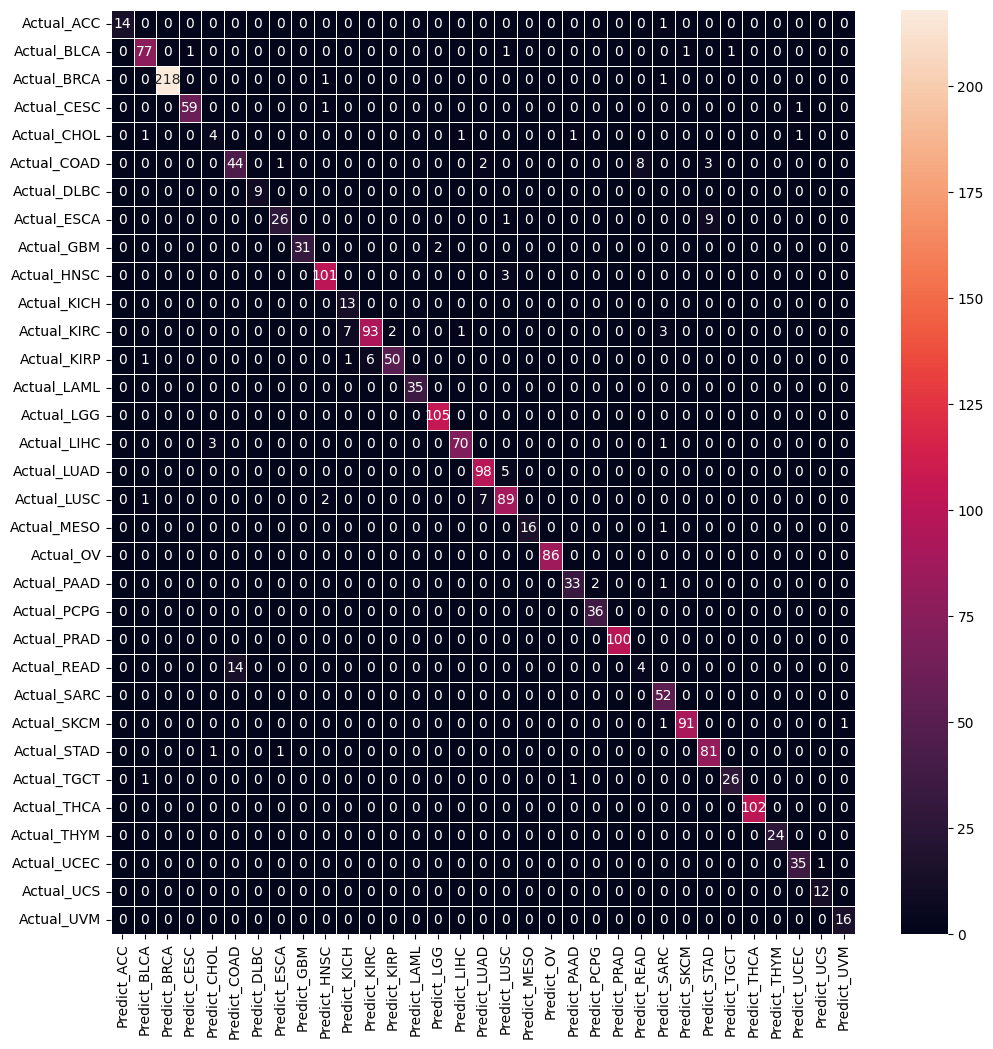

In [ ]:
plot_conf_matrix(cm1,y_test_1)

In [ ]:
# make predictions for test data
predictions_1 = [round(value) for value in y_pred_1]
# evaluate predictions
accuracy_1 = accuracy_score(y_test_1, predictions_1)
print("Accuracy: %.2f%%" % (accuracy_1 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_1 = precision_score(y_test_1, predictions_1, average='micro')
print('Precision for all class: %f' % precision_1)

# recall: tp / (tp + fn)
recall_1 = recall_score(y_test_1, predictions_1,average='micro')
print('Recall: %f' % recall_1)
# f1: 2 tp / (2 tp + fp + fn)
f1_1 = f1_score(y_test_1, predictions_1, average='micro')
print('F1 score: %f' % f1_1)

Accuracy: 94.53%
Precision for all class: 0.945324
Recall: 0.945324
F1 score: 0.945324


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_1' /content/gdrive/MyDrive/gene_seq/

# 2

In [ ]:
test_split_2= pd.read_csv("./test_split_2.csv", sep=',')
test_split_2

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.7469,1.4547,4.4542,-4.2934,10.9842,4.8997,-2.8262,0.7832,-4.0350,1.4911,...,0.8164,-3.6259,0.2881,1.5115,5.9789,-9.9658,29,27,1,5
1953,6.1196,1.5514,3.9194,-3.8160,11.2873,4.3492,1.6420,0.0580,-0.9971,0.1776,...,-0.3752,-5.5735,-4.2934,3.6759,5.3615,-9.9658,29,51,0,5
1954,6.2782,-0.2159,2.4883,-5.5735,12.1155,3.9534,-2.2447,-1.2481,-4.6082,-0.8084,...,-0.9971,-5.0116,-0.5125,3.6301,6.4278,-9.9658,29,29,1,5
1955,6.5600,0.9935,3.5060,-9.9658,11.8054,4.3456,-2.9324,-1.6394,-9.9658,-0.1345,...,-1.1488,-3.4580,0.2522,3.5742,6.2489,-9.9658,29,12,1,5


In [ ]:
test_split_2_dummies = test_split_2.copy()
test_split_2_dummies = pd.get_dummies(test_split_2_dummies)

X_test_2 = test_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_test_2 = test_split_2_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_2= pd.read_csv("./train_split_2.csv", sep=',')
# train_split_1

In [ ]:
train_split_2_dummies = train_split_2.copy()
train_split_2_dummies = pd.get_dummies(train_split_2_dummies)

X_train_2 = train_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_train_2 = train_split_2_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train2=X_train_2.copy()
y_train2=y_train_2.copy()

In [ ]:
X_train_2,X_valid_2,y_train_2 , y_valid_2  = train_test_split(X_train2,y_train2, test_size=0.2, random_state = 42, stratify=y_train_2)

In [ ]:
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

xgb_model_2 = xgb.XGBClassifier(objective="multi:softprob",gpu_id=0,tree_method='gpu_hist', max_depth= 6, random_state=42,
                                   learning_rate= 0.1, n_estimators=1000)
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
xgb_model_2.fit(X_train_2, y_train_2, verbose=True, early_stopping_rounds=10, eval_metric=["merror", "mlogloss"],eval_set=eval_set)


/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-merror:0.04839	validation_0-mlogloss:2.27300	validation_1-merror:0.11497	validation_1-mlogloss:2.34585
[1]	validation_0-merror:0.02651	validation_0-mlogloss:1.87871	validation_1-merror:0.08380	validation_1-mlogloss:1.99149
[2]	validation_0-merror:0.01773	validation_0-mlogloss:1.60646	validation_1-merror:0.07409	validation_1-mlogloss:1.74575
[3]	validation_0-merror:0.01374	validation_0-mlogloss:1.39946	validation_1-merror:0.07103	validation_1-mlogloss:1.55576
[4]	validation_0-merror:0.00942	validation_0-mlogloss:1.23259	validation_1-merror:0.06438	validation_1-mlogloss:1.40503
[5]	validation_0-merror:0.00831	validation_0-mlogloss:1.09447	validation_1-merror:0.06285	validation_1-mlogloss:1.27817
[6]	validation_0-merror:0.00671	validation_0-mlogloss:0.97670	validation_1-merror:0.06183	validation_1-mlogloss:1.17142
[7]	validation_0-merror:0.00559	validation_0-mlogloss:0.87506	validation_1-merror:0.06030	validation_1-mlogloss:1.07740
[8]	validation_0-merror:0.00479	validati

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00837	validation_1-merror:0.04905	validation_1-mlogloss:0.18532
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00804	validation_1-merror:0.04854	validation_1-mlogloss:0.18456
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00773	validation_1-merror:0.04854	validation_1-mlogloss:0.18400
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00744	validation_1-merror:0.04854	validation_1-mlogloss:0.18329
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00717	validation_1-merror:0.04905	validation_1-mlogloss:0.18258
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00692	validation_1-merror:0.04957	validation_1-mlogloss:0.18181
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.00668	validation_1-merror:0.04957	validation_1-mlogloss:0.18120
[75]	validation_0-merror:0.00000	validation_0-mlogloss:0.00645	validation_1-merror:0.04957	validation_1-mlogloss:0.18068
[76]	validation_0-merror:0.00000

[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00279	validation_1-merror:0.04548	validation_1-mlogloss:0.16936
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00277	validation_1-merror:0.04548	validation_1-mlogloss:0.16930
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00276	validation_1-merror:0.04548	validation_1-mlogloss:0.16925
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00274	validation_1-merror:0.04548	validation_1-mlogloss:0.16911
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00273	validation_1-merror:0.04548	validation_1-mlogloss:0.16910
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00271	validation_1-merror:0.04548	validation_1-mlogloss:0.16910
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.00270	validation_1-merror:0.04548	validation_1-mlogloss:0.16898
[143]	validation_0-merror:0.00000	validation_0-mlogloss:0.00269	validation_1-merror:0.04548	validation_1-mlogloss:0.16897
[144]	validation_0-merro

[204]	validation_0-merror:0.00000	validation_0-mlogloss:0.00227	validation_1-merror:0.04446	validation_1-mlogloss:0.16750
[205]	validation_0-merror:0.00000	validation_0-mlogloss:0.00227	validation_1-merror:0.04394	validation_1-mlogloss:0.16758
[206]	validation_0-merror:0.00000	validation_0-mlogloss:0.00226	validation_1-merror:0.04394	validation_1-mlogloss:0.16753


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
xgb_model_2.save_model("xgb_model_2.json")
# model_xgb_2 = xgb.XGBClassifier()
# model_xgb_2.load_model("./xgb_model_2.json")

In [ ]:
y_pred_2 = xgb_model_2.predict(X_test_2)

cm2=(confusion_matrix(y_test_2, y_pred_2))

In [ ]:
# def plot_conf_matrix():
#     labels=y_test_2.unique()
#     cancer_names=[]
#     for i in labels:
#         if i in cancer_name_num_dict.keys():
#             cancer_names.append(cancer_name_num_dict[i])

#     column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
#     indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

#     table= pd.DataFrame(cm, columns=column, index=indices)

#     fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

#     return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

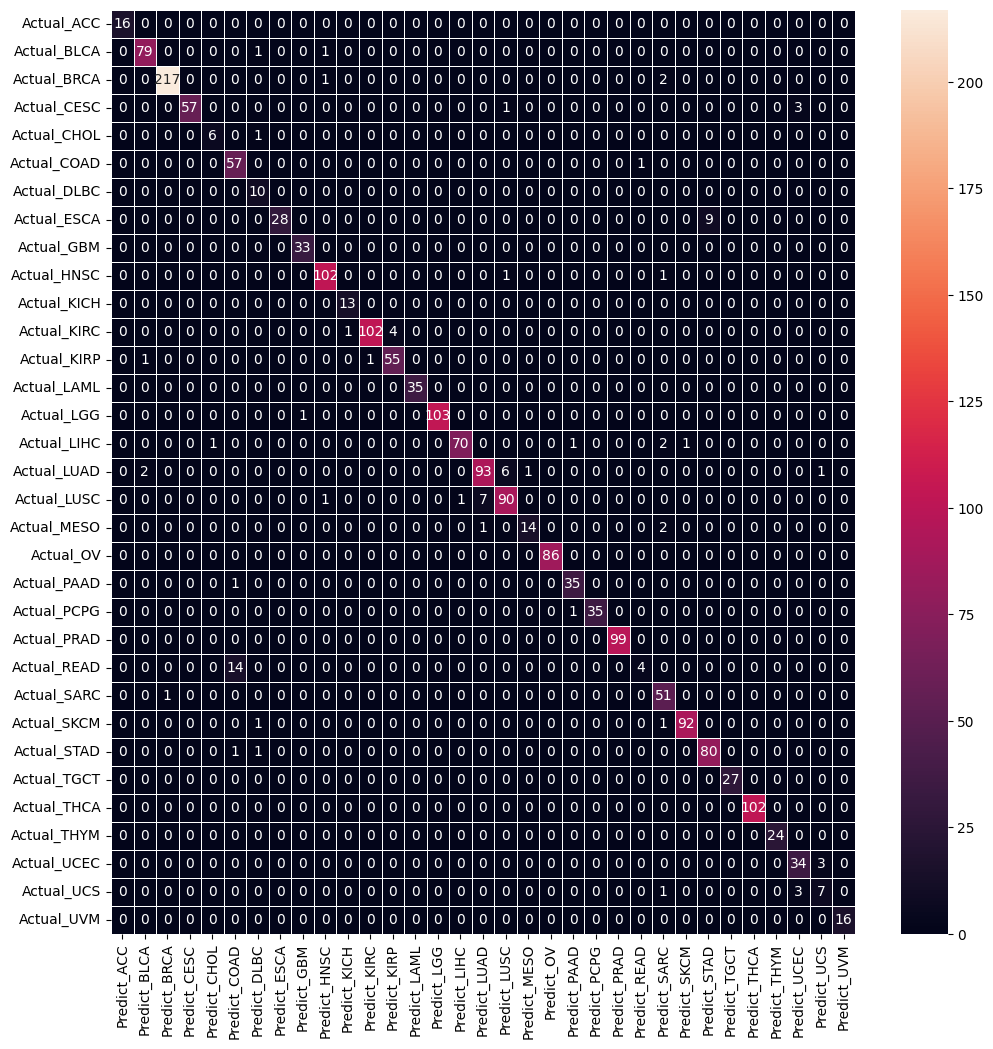

In [ ]:
plot_conf_matrix(cm2,y_test_2)

In [ ]:
# make predictions for test data
predictions_2 = [round(value) for value in y_pred_2]
# evaluate predictions
accuracy_2 = accuracy_score(y_test_2, predictions_2)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_2 = precision_score(y_test_2, predictions_2, average='micro')
print('Precision for all class: %f' % precision_2)

# recall: tp / (tp + fn)
recall_2 = recall_score(y_test_2, predictions_2,average='micro')
print('Recall: %f' % recall_2)
# f1: 2 tp / (2 tp + fp + fn)
f1_2 = f1_score(y_test_2, predictions_2, average='micro')
print('F1 score: %f' % f1_2)

Accuracy: 95.66%
Precision for all class: 0.956566
Recall: 0.956566
F1 score: 0.956566


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_2' /content/gdrive/MyDrive/gene_seq/

# 3

In [ ]:
test_split_3= pd.read_csv("./test_split_3.csv", sep=',')
test_split_3

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.5982,4.1277,4.1261,-6.5064,10.0168,5.6525,-0.3201,-1.1811,-1.3921,1.5950,...,2.1798,-6.5064,1.9034,2.7721,4.6077,-9.9658,8,44,1,5
1,4.6713,3.2450,3.3364,-6.5064,9.3261,5.6372,4.2736,-2.0529,1.0847,1.6558,...,2.4831,-4.0350,1.2875,2.5924,4.6826,-9.9658,8,31,0,5
2,5.7748,4.0593,3.9892,-2.7274,9.2628,4.7645,2.9966,0.6969,-1.1811,1.8363,...,1.0847,-3.6259,-0.1345,1.2636,4.1186,-9.9658,8,49,1,5
3,5.0462,2.1766,3.7836,-3.8160,9.0157,5.3972,0.3907,-0.3940,-0.7834,2.0218,...,1.6920,-2.2447,-0.4921,1.3051,4.7296,-9.9658,8,60,1,5
4,5.2502,3.0092,3.7529,-9.9658,10.4801,5.0206,-0.1031,-1.7322,-2.8262,1.5758,...,-0.2498,-4.6082,0.3115,4.1716,4.0401,-9.9658,8,22,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.6235,1.7141,5.1314,-4.0350,10.5520,4.8954,-0.8863,1.5661,-2.9324,1.7185,...,1.6420,-2.8262,0.7832,2.0638,6.1183,-9.9658,29,53,1,5
1953,4.6770,1.6093,4.5230,-5.5735,10.2727,5.1522,-2.1779,2.3251,-0.6643,1.9968,...,2.2113,-5.0116,-1.6850,1.5415,5.0299,-9.9658,29,58,0,2
1954,5.7115,1.8524,5.2246,-5.5735,10.5343,4.6566,-1.3548,1.8363,-1.1172,2.2753,...,1.9895,-2.4659,1.0222,0.1257,6.1861,-9.9658,29,47,1,5
1955,6.0157,0.5763,3.8279,-9.9658,10.7721,3.9403,-0.9686,-2.5479,-0.6643,0.7058,...,0.6880,-4.6082,-2.1140,2.6325,5.9206,-9.9658,29,3,1,2


In [ ]:
test_split_3_dummies = test_split_3.copy()
test_split_3_dummies = pd.get_dummies(test_split_3_dummies)

X_test_3 = test_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_test_3 = test_split_3_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_3= pd.read_csv("./train_split_3.csv", sep=',')
# train_split_1

In [ ]:
train_split_3_dummies = train_split_3.copy()
train_split_3_dummies = pd.get_dummies(train_split_3_dummies)

X_train_3 = train_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_train_3 = train_split_3_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train3=X_train_3.copy()
y_train3=y_train_3.copy()

In [ ]:
X_train_3,X_valid_3,y_train_3 , y_valid_3  = train_test_split(X_train3,y_train3, test_size=0.2, random_state = 42, stratify=y_train_3)

In [ ]:
eval_set = [(X_train_3, y_train_3), (X_test_3, y_test_3)]

xgb_model_3 = xgb.XGBClassifier(objective="multi:softprob",gpu_id=0,tree_method='gpu_hist', max_depth= 4, random_state=42,
                                   learning_rate= 0.1, n_estimators=1000,)
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
xgb_model_3.fit(X_train_3, y_train_3, verbose=True, early_stopping_rounds=10, eval_metric=["merror", "mlogloss"],eval_set=eval_set)


/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-merror:0.06373	validation_0-mlogloss:2.28670	validation_1-merror:0.11191	validation_1-mlogloss:2.32832
[1]	validation_0-merror:0.03881	validation_0-mlogloss:1.90143	validation_1-merror:0.08482	validation_1-mlogloss:1.97860
[2]	validation_0-merror:0.02971	validation_0-mlogloss:1.63355	validation_1-merror:0.08022	validation_1-mlogloss:1.73233
[3]	validation_0-merror:0.02412	validation_0-mlogloss:1.42807	validation_1-merror:0.07256	validation_1-mlogloss:1.54186
[4]	validation_0-merror:0.01917	validation_0-mlogloss:1.26251	validation_1-merror:0.06745	validation_1-mlogloss:1.38833
[5]	validation_0-merror:0.01725	validation_0-mlogloss:1.12469	validation_1-merror:0.06183	validation_1-mlogloss:1.26062
[6]	validation_0-merror:0.01485	validation_0-mlogloss:1.00750	validation_1-merror:0.05825	validation_1-mlogloss:1.15181
[7]	validation_0-merror:0.01421	validation_0-mlogloss:0.90648	validation_1-merror:0.05876	validation_1-mlogloss:1.05702
[8]	validation_0-merror:0.01310	validati

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00985	validation_1-merror:0.03986	validation_1-mlogloss:0.14872
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00945	validation_1-merror:0.03986	validation_1-mlogloss:0.14792
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00907	validation_1-merror:0.04088	validation_1-mlogloss:0.14711
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00872	validation_1-merror:0.04037	validation_1-mlogloss:0.14625
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00839	validation_1-merror:0.03986	validation_1-mlogloss:0.14572
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00808	validation_1-merror:0.03986	validation_1-mlogloss:0.14495
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.00778	validation_1-merror:0.03986	validation_1-mlogloss:0.14433
[75]	validation_0-merror:0.00000	validation_0-mlogloss:0.00751	validation_1-merror:0.03986	validation_1-mlogloss:0.14361
[76]	validation_0-merror:0.00000

[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00297	validation_1-merror:0.04037	validation_1-mlogloss:0.13058
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00295	validation_1-merror:0.04037	validation_1-mlogloss:0.13053
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00293	validation_1-merror:0.04037	validation_1-mlogloss:0.13046
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00291	validation_1-merror:0.04037	validation_1-mlogloss:0.13041
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00290	validation_1-merror:0.04037	validation_1-mlogloss:0.13034
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00288	validation_1-merror:0.04037	validation_1-mlogloss:0.13028
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.00286	validation_1-merror:0.04037	validation_1-mlogloss:0.13028
[143]	validation_0-merror:0.00000	validation_0-mlogloss:0.00285	validation_1-merror:0.04037	validation_1-mlogloss:0.13026
[144]	validation_0-merro

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
xgb_model_3.save_model("xgb_model_3.json")
# model_xgb_3 = xgb.XGBClassifier()
# model_xgb_3.load_model("./xgb_model_3.json")

In [ ]:
y_pred_3 = xgb_model_3.predict(X_test_3)

cm3=(confusion_matrix(y_test_3, y_pred_3))

In [ ]:
# def plot_conf_matrix():
#     labels=y_test_3.unique()
#     cancer_names=[]
#     for i in labels:
#         if i in cancer_name_num_dict.keys():
#             cancer_names.append(cancer_name_num_dict[i])

#     column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
#     indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

#     table= pd.DataFrame(cm, columns=column, index=indices)

#     fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

#     return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

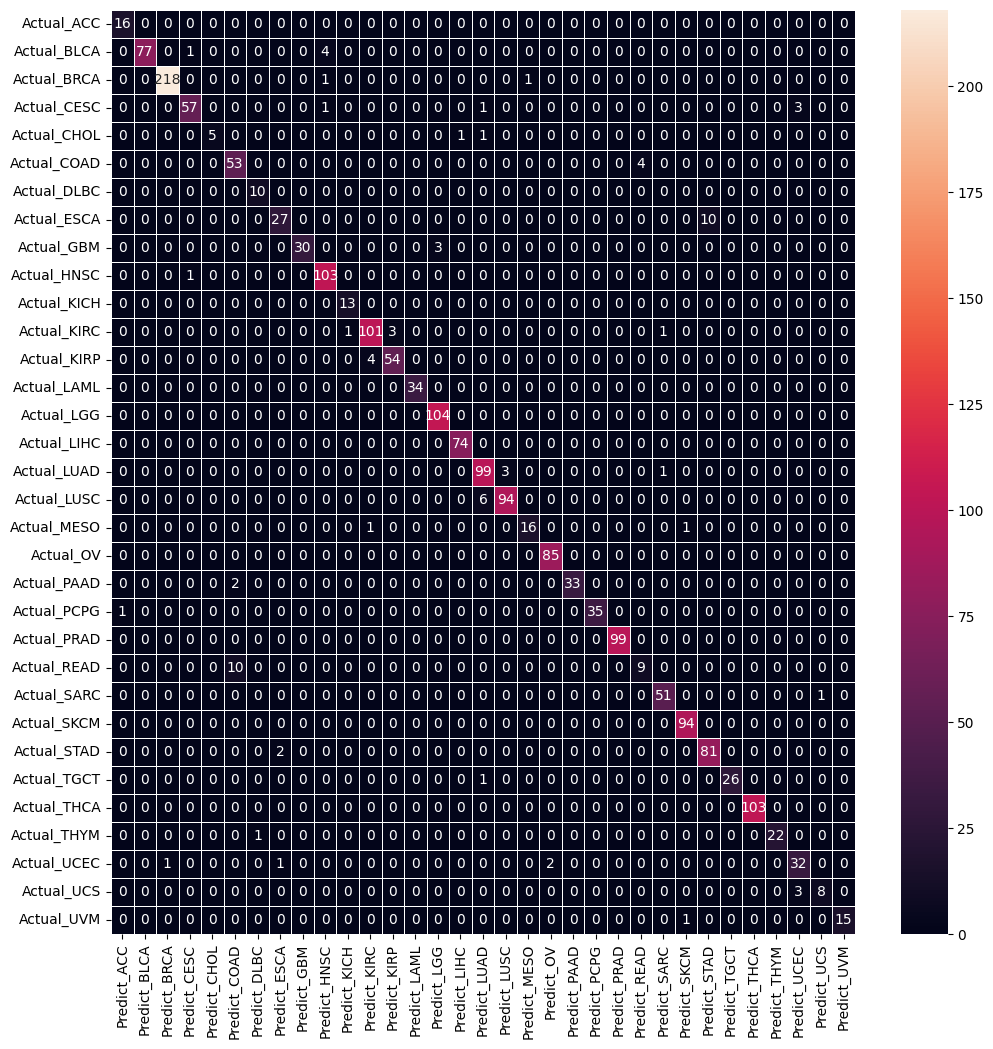

In [ ]:
plot_conf_matrix(cm3,y_test_3)

In [ ]:
# make predictions for test data
predictions_3 = [round(value) for value in y_pred_3]
# evaluate predictions
accuracy_3 = accuracy_score(y_test_3, predictions_3)
print("Accuracy: %.2f%%" % (accuracy_3 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_3 = precision_score(y_test_3, predictions_3, average='micro')
print('Precision for all class: %f' % precision_3)

# recall: tp / (tp + fn)
recall_3 = recall_score(y_test_3, predictions_3,average='micro')
print('Recall: %f' % recall_3)
# f1: 2 tp / (2 tp + fp + fn)
f1_3 = f1_score(y_test_3, predictions_3, average='micro')
print('F1 score: %f' % f1_3)

Accuracy: 95.96%
Precision for all class: 0.959632
Recall: 0.959632
F1 score: 0.959632


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_3' /content/gdrive/MyDrive/gene_seq/

# 4

In [ ]:
test_split_4= pd.read_csv("./test_split_4.csv", sep=',')
test_split_4

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.7138,4.1178,2.9090,-1.7809,9.5309,5.4973,-1.4305,-1.7809,-0.2498,0.6425,...,2.4063,-4.0350,-2.5479,3.4635,4.3541,-9.9658,8,37,1,5
1,4.5318,2.5876,5.2642,-9.9658,9.6668,4.8580,-4.2934,-2.8262,-2.4659,2.2051,...,0.7407,-9.9658,-3.0469,0.9268,5.2499,-9.9658,8,49,0,5
2,4.8324,3.0411,3.7794,-5.5735,9.6898,5.1102,7.4223,-2.4659,1.0573,1.4228,...,2.0395,-1.3921,-1.9379,0.7579,4.7986,-9.9658,8,34,1,5
3,4.9397,2.5561,3.9459,-6.5064,9.4092,5.3958,3.4304,-0.6416,-0.4521,2.1541,...,1.4174,-9.9658,-0.2159,0.7832,4.9855,-9.9658,8,41,0,3
4,5.2502,2.3251,3.8401,-9.9658,10.0487,5.3961,0.8726,-1.7322,-0.0725,2.5338,...,1.8840,-1.2828,1.0983,2.6738,4.1820,-9.9658,8,56,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.4813,2.4252,5.9570,-1.6850,9.9599,4.9251,-0.9406,1.5115,-0.0425,2.2723,...,1.4808,-0.9406,1.0915,1.9931,5.9258,-9.9658,29,32,1,5
1953,4.0567,1.3679,5.4219,0.7664,9.8447,4.7677,-0.5973,3.5299,-3.4580,2.4306,...,2.5900,-4.0350,-2.8262,0.2881,4.9103,-9.9658,29,56,1,5
1954,4.6165,1.6512,5.2032,0.4125,9.9029,4.7285,1.9638,1.7446,-0.2671,1.3956,...,1.7229,-3.8160,-5.5735,-0.7346,4.9458,-9.9658,29,61,0,5
1955,5.6691,1.7660,5.2480,-4.2934,10.7449,3.9270,-0.3940,0.8568,0.6517,1.1770,...,0.8568,-3.6259,-9.9658,2.0912,5.4125,-9.9658,29,64,0,5


In [ ]:
test_split_4_dummies = test_split_4.copy()
test_split_4_dummies = pd.get_dummies(test_split_4_dummies)

X_test_4 = test_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_test_4 = test_split_4_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_4= pd.read_csv("./train_split_4.csv", sep=',')
# train_split_1

In [ ]:
train_split_4_dummies = train_split_4.copy()
train_split_4_dummies = pd.get_dummies(train_split_4_dummies)

X_train_4 = train_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_train_4 = train_split_4_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train4=X_train_4.copy()
y_train4=y_train_4.copy()

In [ ]:
X_train_4,X_valid_4,y_train_4 , y_valid_4  = train_test_split(X_train4,y_train4, test_size=0.2, random_state = 42, stratify=y_train4)

In [ ]:
eval_set = [(X_train_4, y_train_4), (X_test_4, y_test_4)]

xgb_model_4 = xgb.XGBClassifier(objective="multi:softprob",gpu_id=0,tree_method='gpu_hist', max_depth= 4, random_state=42,
                                   learning_rate= 0.1, n_estimators=1000)
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
xgb_model_4.fit(X_train_4, y_train_4, verbose=True, early_stopping_rounds=10, eval_metric=["merror", "mlogloss"],eval_set=eval_set)


/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-merror:0.06053	validation_0-mlogloss:2.28305	validation_1-merror:0.12672	validation_1-mlogloss:2.35383
[1]	validation_0-merror:0.03737	validation_0-mlogloss:1.89589	validation_1-merror:0.08789	validation_1-mlogloss:1.99690
[2]	validation_0-merror:0.02667	validation_0-mlogloss:1.62748	validation_1-merror:0.07869	validation_1-mlogloss:1.75325
[3]	validation_0-merror:0.02204	validation_0-mlogloss:1.42251	validation_1-merror:0.07563	validation_1-mlogloss:1.56610
[4]	validation_0-merror:0.01837	validation_0-mlogloss:1.25715	validation_1-merror:0.06898	validation_1-mlogloss:1.41478
[5]	validation_0-merror:0.01581	validation_0-mlogloss:1.11925	validation_1-merror:0.06643	validation_1-mlogloss:1.28753
[6]	validation_0-merror:0.01358	validation_0-mlogloss:1.00193	validation_1-merror:0.06438	validation_1-mlogloss:1.17752
[7]	validation_0-merror:0.01198	validation_0-mlogloss:0.90075	validation_1-merror:0.06285	validation_1-mlogloss:1.08275
[8]	validation_0-merror:0.01070	validati

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00966	validation_1-merror:0.04190	validation_1-mlogloss:0.16297
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00926	validation_1-merror:0.04190	validation_1-mlogloss:0.16223
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00889	validation_1-merror:0.04241	validation_1-mlogloss:0.16138
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00854	validation_1-merror:0.04190	validation_1-mlogloss:0.16071
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00822	validation_1-merror:0.04190	validation_1-mlogloss:0.15993
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00792	validation_1-merror:0.04241	validation_1-mlogloss:0.15932
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.00763	validation_1-merror:0.04241	validation_1-mlogloss:0.15881
[75]	validation_0-merror:0.00000	validation_0-mlogloss:0.00737	validation_1-merror:0.04241	validation_1-mlogloss:0.15825
[76]	validation_0-merror:0.00000

[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00295	validation_1-merror:0.04292	validation_1-mlogloss:0.14732
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00293	validation_1-merror:0.04292	validation_1-mlogloss:0.14720
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00291	validation_1-merror:0.04292	validation_1-mlogloss:0.14716
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00290	validation_1-merror:0.04292	validation_1-mlogloss:0.14710
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00288	validation_1-merror:0.04292	validation_1-mlogloss:0.14702
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00287	validation_1-merror:0.04292	validation_1-mlogloss:0.14704
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.00285	validation_1-merror:0.04292	validation_1-mlogloss:0.14706
[143]	validation_0-merror:0.00000	validation_0-mlogloss:0.00283	validation_1-merror:0.04292	validation_1-mlogloss:0.14700
[144]	validation_0-merro

[204]	validation_0-merror:0.00000	validation_0-mlogloss:0.00230	validation_1-merror:0.04190	validation_1-mlogloss:0.14515
[205]	validation_0-merror:0.00000	validation_0-mlogloss:0.00229	validation_1-merror:0.04190	validation_1-mlogloss:0.14512
[206]	validation_0-merror:0.00000	validation_0-mlogloss:0.00229	validation_1-merror:0.04190	validation_1-mlogloss:0.14513
[207]	validation_0-merror:0.00000	validation_0-mlogloss:0.00228	validation_1-merror:0.04190	validation_1-mlogloss:0.14512
[208]	validation_0-merror:0.00000	validation_0-mlogloss:0.00228	validation_1-merror:0.04190	validation_1-mlogloss:0.14514
[209]	validation_0-merror:0.00000	validation_0-mlogloss:0.00228	validation_1-merror:0.04190	validation_1-mlogloss:0.14520
[210]	validation_0-merror:0.00000	validation_0-mlogloss:0.00227	validation_1-merror:0.04190	validation_1-mlogloss:0.14518
[211]	validation_0-merror:0.00000	validation_0-mlogloss:0.00227	validation_1-merror:0.04190	validation_1-mlogloss:0.14519
[212]	validation_0-merro

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
xgb_model_4.save_model("xgb_model_4.json")
# model_xgb_4 = xgb.XGBClassifier()
# model_xgb_4.load_model("./xgb_model_4.json")

In [ ]:
y_pred_4 = xgb_model_4.predict(X_test_4)

cm4=(confusion_matrix(y_test_4, y_pred_4))

In [ ]:
# def plot_conf_matrix():
#     labels=y_test_4.unique()
#     cancer_names=[]
#     for i in labels:
#         if i in cancer_name_num_dict.keys():
#             cancer_names.append(cancer_name_num_dict[i])

#     column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
#     indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

#     table= pd.DataFrame(cm, columns=column, index=indices)

#     fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

#     return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

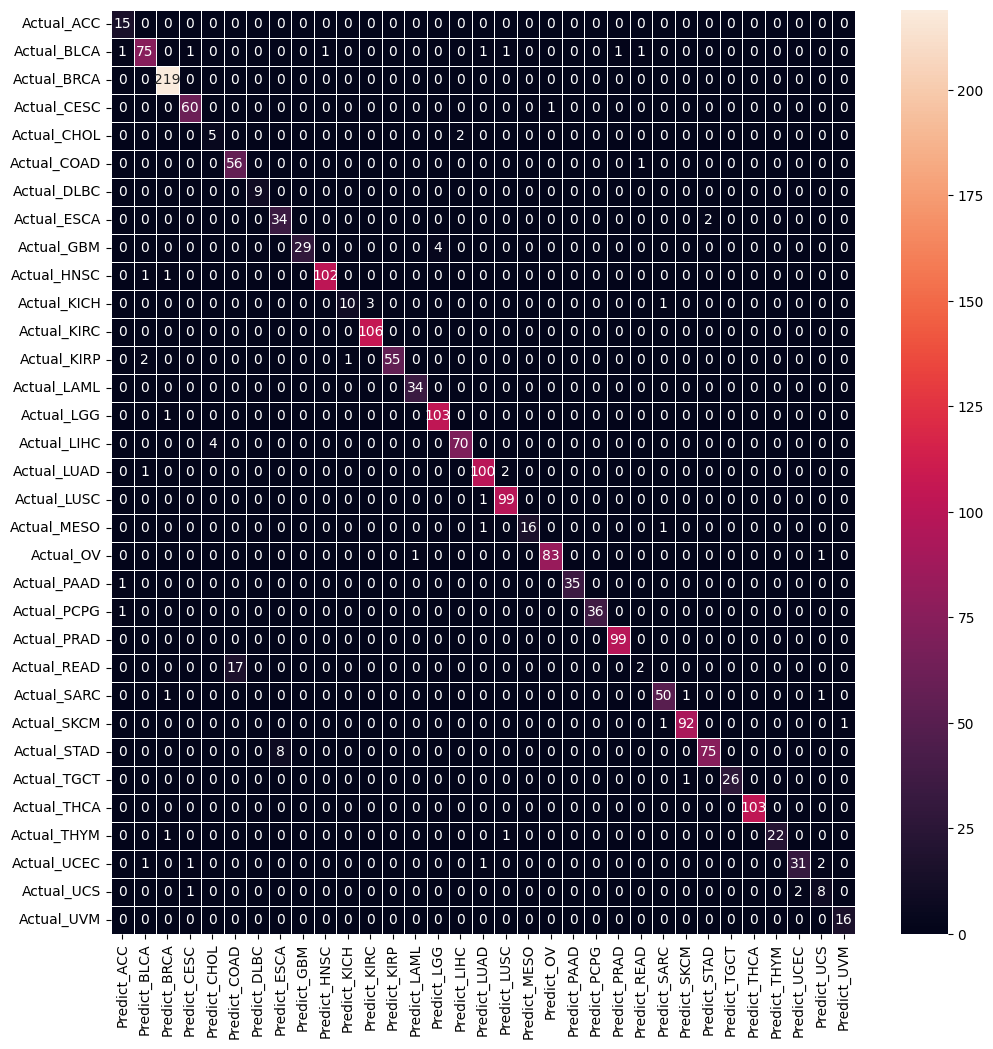

In [ ]:
plot_conf_matrix(cm4,y_test_4)

In [ ]:
# make predictions for test data
predictions_4 = [round(value) for value in y_pred_4]
# evaluate predictions
accuracy_4 = accuracy_score(y_test_4, predictions_4)
print("Accuracy: %.2f%%" % (accuracy_4 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_4 = precision_score(y_test_4, predictions_4, average='micro')
print('Precision for all class: %f' % precision_4)

# recall: tp / (tp + fn)
recall_4 = recall_score(y_test_4, predictions_4,average='micro')
print('Recall: %f' % recall_4)
# f1: 2 tp / (2 tp + fp + fn)
f1_4 = f1_score(y_test_4, predictions_4, average='micro')
print('F1 score: %f' % f1_4)

Accuracy: 95.81%
Precision for all class: 0.958099
Recall: 0.958099
F1 score: 0.958099


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_4' /content/gdrive/MyDrive/gene_seq/

# 5

In [ ]:
test_split_5= pd.read_csv("./test_split_5.csv", sep=',')
test_split_5

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.6759,2.4960,3.4609,-4.6082,9.7135,5.7955,1.3109,1.0293,-3.0469,1.3567,...,1.9490,-3.0469,-3.0469,1.7273,4.9691,-9.9658,8,63,0,5
1,5.8829,3.0252,3.3119,-6.5064,9.4547,5.4900,1.4174,-1.4305,-1.8836,1.8801,...,1.4011,-5.0116,-0.3383,3.7561,5.0184,-9.9658,8,55,0,5
2,5.8199,2.8076,3.9031,-6.5064,9.2346,5.6787,0.6425,-0.3383,-2.3147,3.0110,...,1.4120,-4.6082,2.2330,4.2111,5.2877,-9.9658,8,31,1,2
3,5.3162,4.2758,3.4437,-5.5735,9.8965,5.6303,0.4447,-1.0559,-0.4921,1.9564,...,1.8363,-5.0116,-5.5735,3.4411,5.1148,-9.9658,8,58,1,5
4,5.1339,2.9186,3.5299,-3.6259,9.6870,5.7436,3.0446,1.7446,-0.4131,2.0638,...,1.5013,-3.4580,1.1184,1.9377,4.1555,-9.9658,8,57,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
1952,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
1953,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
1954,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [ ]:
test_split_5_dummies = test_split_5.copy()
test_split_5_dummies = pd.get_dummies(test_split_5_dummies)

X_test_5 = test_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_test_5 = test_split_5_dummies['cancer type abbreviation'].copy()

In [ ]:
train_split_5= pd.read_csv("./train_split_5.csv", sep=',')
# train_split_1

In [ ]:
train_split_5_dummies = train_split_5.copy()
train_split_5_dummies = pd.get_dummies(train_split_5_dummies)

X_train_5 = train_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_train_5 = train_split_5_dummies['cancer type abbreviation'].copy()

In [ ]:
X_train5=X_train_5.copy()
y_train5=y_train_5.copy()

In [ ]:
X_train_5,X_valid_5,y_train_5 , y_valid_5  = train_test_split(X_train5,y_train5, test_size=0.2, random_state = 42, stratify=y_train5)

In [ ]:
eval_set = [(X_train_5, y_train_5), (X_test_5, y_test_5)]

xgb_model_5 = xgb.XGBClassifier(objective="multi:softprob",gpu_id=0,tree_method='gpu_hist', max_depth= 4, random_state=42,
                                   learning_rate= 0.1, n_estimators=1000,)
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
xgb_model_5.fit(X_train_5, y_train_5, verbose=True, early_stopping_rounds=10, eval_metric=["merror", "mlogloss"],eval_set=eval_set)


/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/home/dlpc01/anaconda3/envs/zs3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-merror:0.05925	validation_0-mlogloss:2.28425	validation_1-merror:0.14008	validation_1-mlogloss:2.38871
[1]	validation_0-merror:0.03577	validation_0-mlogloss:1.89312	validation_1-merror:0.10327	validation_1-mlogloss:2.03684
[2]	validation_0-merror:0.02635	validation_0-mlogloss:1.62375	validation_1-merror:0.08691	validation_1-mlogloss:1.79506
[3]	validation_0-merror:0.02204	validation_0-mlogloss:1.41835	validation_1-merror:0.08282	validation_1-mlogloss:1.61115
[4]	validation_0-merror:0.01773	validation_0-mlogloss:1.25279	validation_1-merror:0.08180	validation_1-mlogloss:1.46129
[5]	validation_0-merror:0.01485	validation_0-mlogloss:1.11527	validation_1-merror:0.07873	validation_1-mlogloss:1.33484
[6]	validation_0-merror:0.01309	validation_0-mlogloss:0.99811	validation_1-merror:0.07669	validation_1-mlogloss:1.22828
[7]	validation_0-merror:0.01214	validation_0-mlogloss:0.89710	validation_1-merror:0.07515	validation_1-mlogloss:1.13548
[8]	validation_0-merror:0.01134	validati

[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00955	validation_1-merror:0.04703	validation_1-mlogloss:0.18726
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00916	validation_1-merror:0.04806	validation_1-mlogloss:0.18597
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00880	validation_1-merror:0.04806	validation_1-mlogloss:0.18503
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00846	validation_1-merror:0.04703	validation_1-mlogloss:0.18368
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00815	validation_1-merror:0.04755	validation_1-mlogloss:0.18278
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00785	validation_1-merror:0.04755	validation_1-mlogloss:0.18188
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.00757	validation_1-merror:0.04652	validation_1-mlogloss:0.18098
[75]	validation_0-merror:0.00000	validation_0-mlogloss:0.00731	validation_1-merror:0.04703	validation_1-mlogloss:0.18012
[76]	validation_0-merror:0.00000

[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00294	validation_1-merror:0.04397	validation_1-mlogloss:0.16758
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00292	validation_1-merror:0.04346	validation_1-mlogloss:0.16741
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00291	validation_1-merror:0.04346	validation_1-mlogloss:0.16737
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00289	validation_1-merror:0.04346	validation_1-mlogloss:0.16732
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00287	validation_1-merror:0.04346	validation_1-mlogloss:0.16739
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00286	validation_1-merror:0.04346	validation_1-mlogloss:0.16735
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.00284	validation_1-merror:0.04346	validation_1-mlogloss:0.16735
[143]	validation_0-merror:0.00000	validation_0-mlogloss:0.00283	validation_1-merror:0.04346	validation_1-mlogloss:0.16735
[144]	validation_0-merro

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
xgb_model_5.save_model("xgb_model_5.json")
# model_xgb_5 = xgb.XGBClassifier()
# model_xgb_5.load_model("./xgb_model_5.json")

In [ ]:
y_pred_5 = xgb_model_5.predict(X_test_5)

cm5=(confusion_matrix(y_test_5, y_pred_5))

In [ ]:
# def plot_conf_matrix():
#     labels=y_test_5.unique()
#     cancer_names=[]
#     for i in labels:
#         if i in cancer_name_num_dict.keys():
#             cancer_names.append(cancer_name_num_dict[i])

#     column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
#     indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

#     table= pd.DataFrame(cm, columns=column, index=indices)

#     fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

#     return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

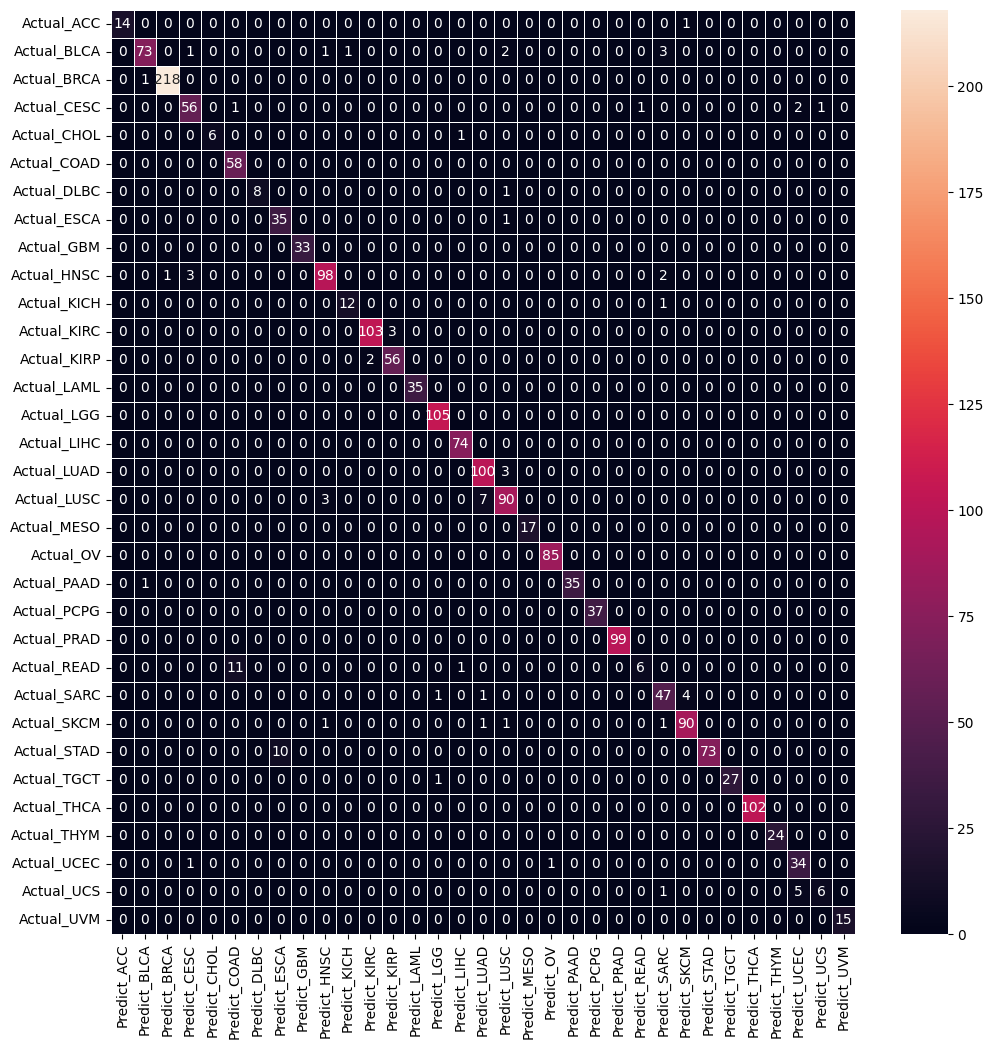

In [ ]:
plot_conf_matrix(cm5, y_test_5)

In [ ]:
# make predictions for test data
predictions_5 = [round(value) for value in y_pred_5]
# evaluate predictions
accuracy_5 = accuracy_score(y_test_5, predictions_5)
print("Accuracy: %.2f%%" % (accuracy_5 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_5 = precision_score(y_test_5, predictions_5, average='micro')
print('Precision for all class: %f' % precision_5)

# recall: tp / (tp + fn)
recall_5 = recall_score(y_test_5, predictions_5,average='micro')
print('Recall: %f' % recall_5)
# f1: 2 tp / (2 tp + fp + fn)
f1_5 = f1_score(y_test_5, predictions_5, average='micro')
print('F1 score: %f' % f1_5)

Accuracy: 95.65%
Precision for all class: 0.956544
Recall: 0.956544
F1 score: 0.956544


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_5' /content/gdrive/MyDrive/gene_seq/

# avg accuracy

In [ ]:
avg_acc=(accuracy_1+accuracy_2+accuracy_3+accuracy_4+accuracy_5)/5
avg_acc

0.9552331674979335

In [ ]:
cm=cm1+cm2+cm3+cm4+cm5

In [ ]:
def plot_final_conf_matrix():
    labels=unique_labels(y_test_5)
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])

    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]

    table= pd.DataFrame(cm, columns=column, index=indices)

    fig, ax = pyplot.subplots(figsize=(20,20))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

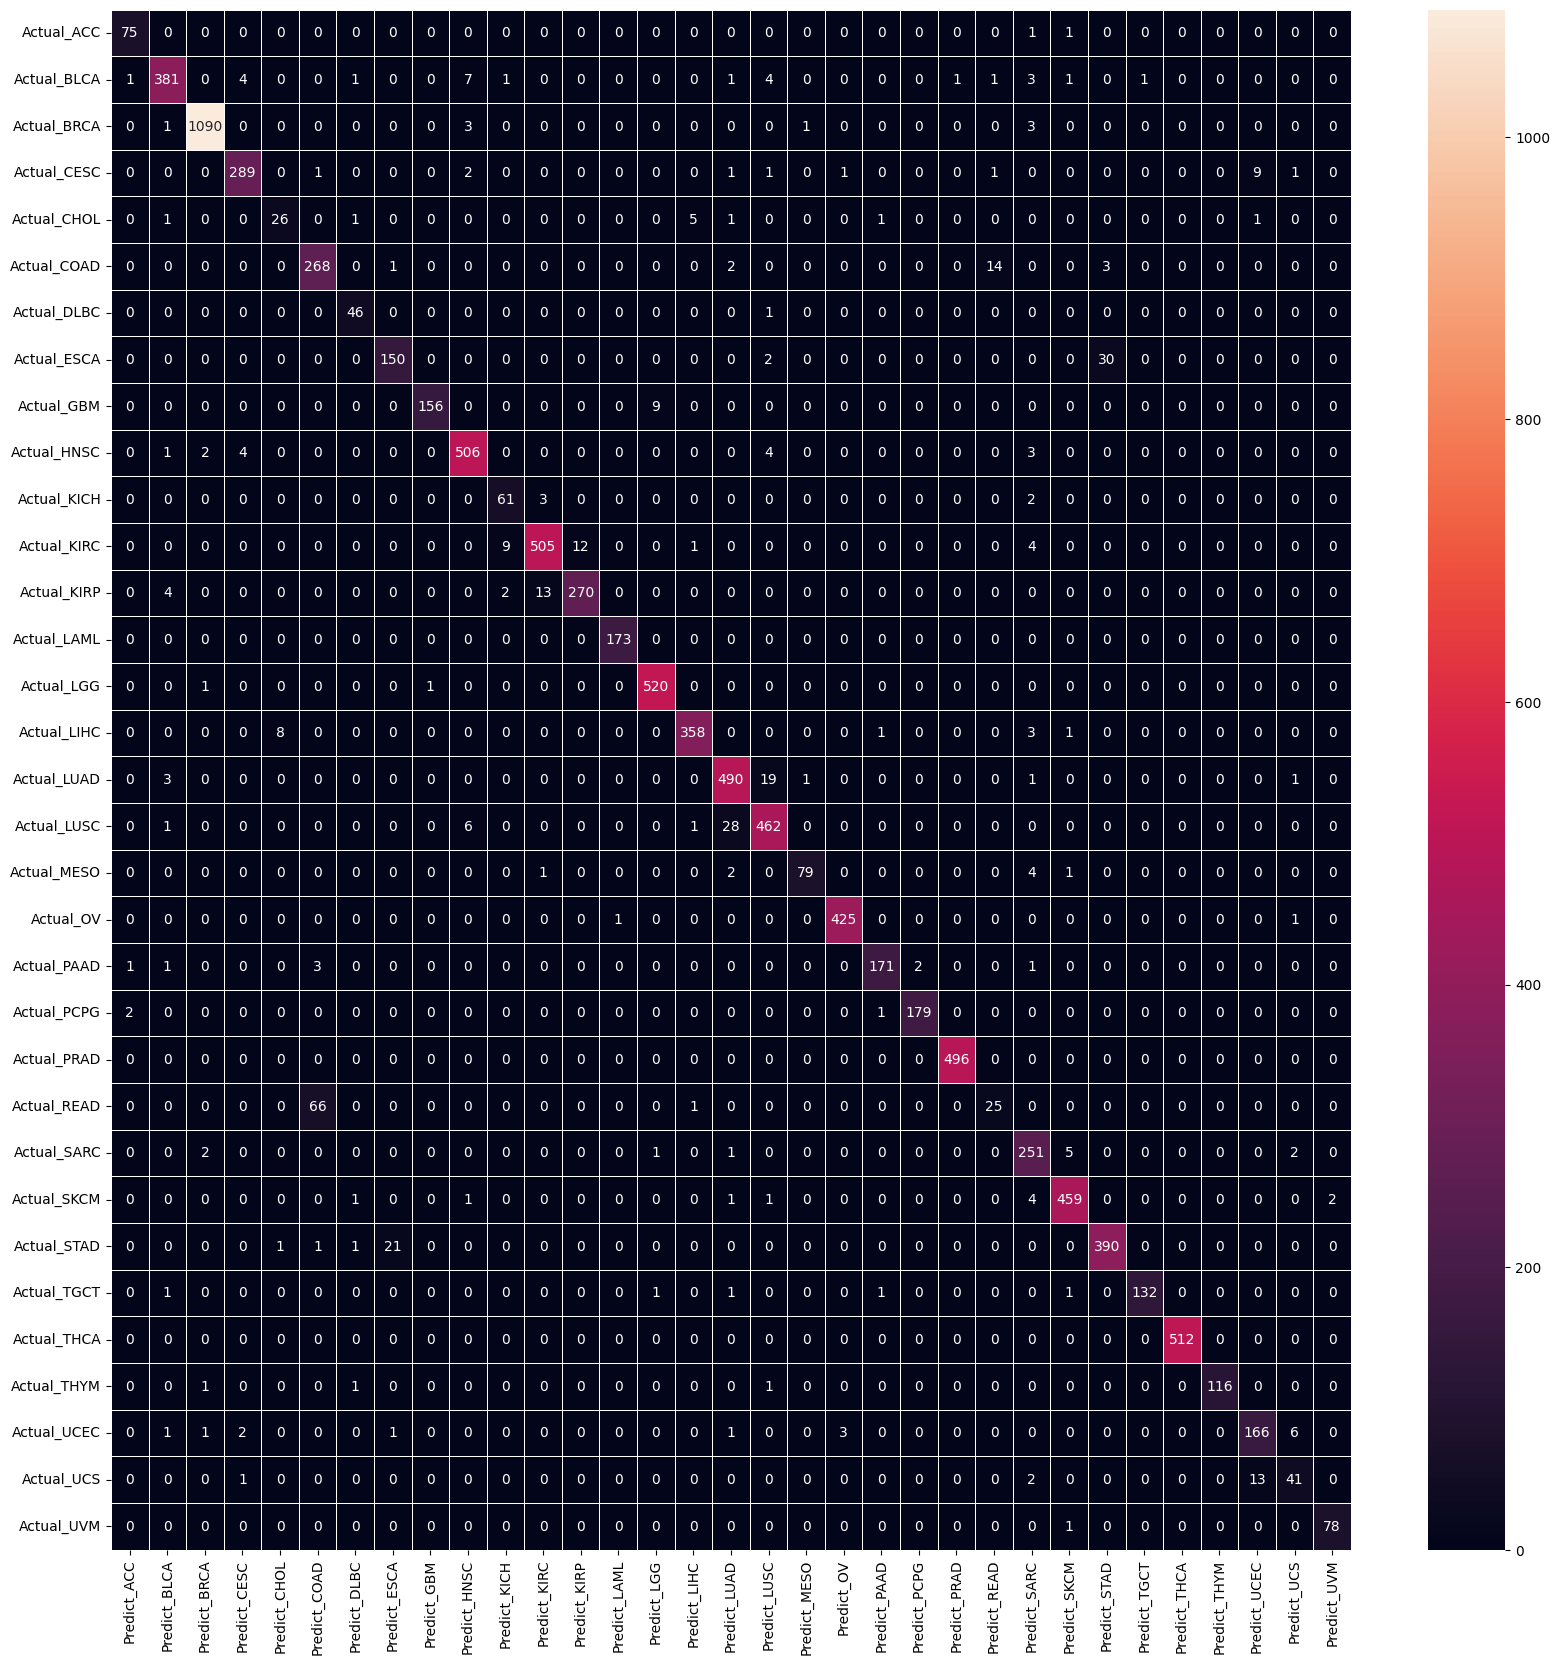

In [ ]:
plot_final_conf_matrix()